**Подключение библиотек и скриптов**

In [2]:
#pip install catboost
#pip install feature_engine

import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV


from catboost import CatBoostRegressor, Pool


from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
%config InlineBackend.figure_format = 'svg'

In [6]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=[10,5])
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    
    plt.subplots_adjust(wspace=.5)

    plt.show()

**Пути к директориям и файлам**

In [1]:
TRAIN_DATASET_PATH = 'kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = 'kaggle/input/real-estate-price-prediction-moscow/test.csv'

### Загрузка данных <a class='anchor' id='load'>

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
9995   1260          61    2.0  49.090728   33.272626            6.0      3   
9996  16265          27    2.0  64.307684   37.038420            9.0     13   
9997   2795         178    1.0  29.648057   16.555363            5.0      3   
9998  14561          21    1.0  32.330292   22.326870            5.0      3   
9999   7202          94    1.0  35.815476   22.301367            6.0      9   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
9995        12.0       1981   0.300323         B         B        52   
9996         0.0       1977   0.072158         B         B         2   
9997         5.0       1958   0.460556         B         B        20   
9998         9.0       1969   0.194489         B         B        47   
9999         9.0       1975   0.127376         B         B        43   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  \
9995     10311         6           NaN            1        9       B   
9996       629         1           NaN            0        0       A   
9997      4386        14           NaN            1        5       B   
9998      8004         3         125.0            3        5       B   
9999      8429         3           NaN            3        9       B   

              Price  
9995  119367.455796  
9996  199715.148807  
9997  165953.912580  
9998  171842.411855  
9999  177685.627486

In [635]:
(train_df['KitchenSquare']==0).sum()

697

In [636]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
4995  10379          29    2.0  43.177521   30.339945            5.0      6   
4996  16138          38    3.0  93.698122   94.521465           10.0     21   
4997   3912         101    1.0  33.656723   19.003259            5.0      2   
4998   5722          10    1.0  38.635155   20.976257            9.0      8   
4999  11004          21    2.0  67.122742   33.944344           13.0      9   

      HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  \
4995         5.0       1962   0.069660         B         B        31   
4996        27.0       2018   0.060753         B         B        15   
4997         5.0       1966   0.038693         B         B        28   
4998        14.0       1970   0.089040         B         B        33   
4999        17.0       2009   0.194489         B         B        47   

      Social_2  Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2  
4995      6119         4           NaN            1        2       B  
4996      2787         2         520.0            0        7       B  
4997      6533         1        1015.0            2        5       B  
4998      7976         5           NaN            0       11       B  
4999      8004         3         125.0            3        5       B

In [638]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


### EDA

In [639]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

**Номинативные переменные**

In [640]:
train_df.select_dtypes(include='object').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

In [641]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
205      1
174      1
209      1
207      1
Name: DistrictId, Length: 205, dtype: int64

In [642]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [643]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [644]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

**Количественные переменные**

In [645]:
train_df.describe()

Id    DistrictId         Rooms        Square   LifeSquare  \
count  10000.00000  10000.000000  10000.000000  10000.000000  7887.000000   
mean    8383.40770     50.400800      1.890500     56.315775    37.199645   
std     4859.01902     43.587592      0.839512     21.058732    86.241209   
min        0.00000      0.000000      0.000000      1.136859     0.370619   
25%     4169.50000     20.000000      1.000000     41.774881    22.769832   
50%     8394.50000     36.000000      2.000000     52.513310    32.781260   
75%    12592.50000     75.000000      2.000000     65.900625    45.128803   
max    16798.00000    209.000000     19.000000    641.065193  7480.592129   

       KitchenSquare         Floor    HouseFloor     HouseYear     Ecology_1  \
count   10000.000000  10000.000000  10000.000000  1.000000e+04  10000.000000   
mean        6.273300      8.526700     12.609400  3.990166e+03      0.118858   
std        28.560917      5.241148      6.775974  2.005003e+05      0.119025   
min         0.000000      1.000000      0.000000  1.910000e+03      0.000000   
25%         1.000000      4.000000      9.000000  1.974000e+03      0.017647   
50%         6.000000      7.000000     13.000000  1.977000e+03      0.075424   
75%         9.000000     12.000000     17.000000  2.001000e+03      0.195781   
max      2014.000000     42.000000    117.000000  2.005201e+07      0.521867   

           Social_1      Social_2      Social_3  Healthcare_1   Helthcare_2  \
count  10000.000000  10000.000000  10000.000000   5202.000000  10000.000000   
mean      24.687000   5352.157400      8.039200   1142.904460      1.319500   
std       17.532614   4006.799803     23.831875   1021.517264      1.493601   
min        0.000000    168.000000      0.000000      0.000000      0.000000   
25%        6.000000   1564.000000      0.000000    350.000000      0.000000   
50%       25.000000   5285.000000      2.000000    900.000000      1.000000   
75%       36.000000   7227.000000      5.000000   1548.000000      2.000000   
max       74.000000  19083.000000    141.000000   4849.000000      6.000000   

            Shops_1          Price  
count  10000.000000   10000.000000  
mean       4.231300  214138.857399  
std        4.806341   92872.293865  
min        0.000000   59174.778028  
25%        1.000000  153872.633942  
50%        3.000000  192269.644879  
75%        6.000000  249135.462171  
max       23.000000  633233.466570

array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>],
       [<AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>,
        <AxesSubplot:title={'center':'Ecology_1'}>],
       [<AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>],
       [<AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>,
        <AxesSubplot:title={'center':'Price'}>, <AxesSubplot:>]],
      dtype=object)

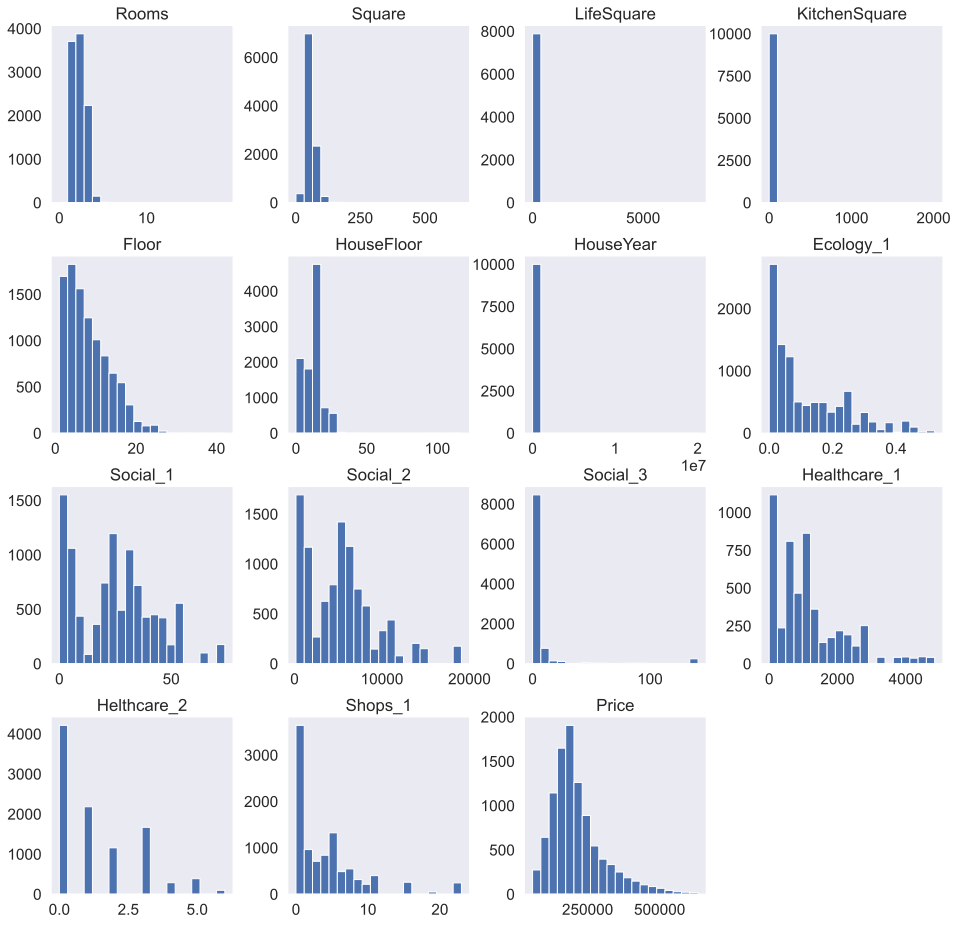

In [646]:
df_num_features = train_df.loc[:, ~train_df.columns.isin(['Id', 'DistrictId'])]
df_num_features = df_num_features.select_dtypes(include=['float64', 'int64'])

df_num_features.hist(figsize=(16,16), bins=20, grid=False)

In [648]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

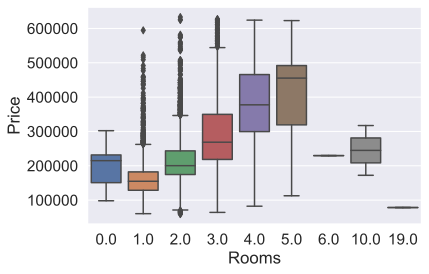

In [649]:
plt.figure()

sns.boxplot(x=train_df['Rooms'], y=train_df['Price'], whis=1.5)

plt.show()

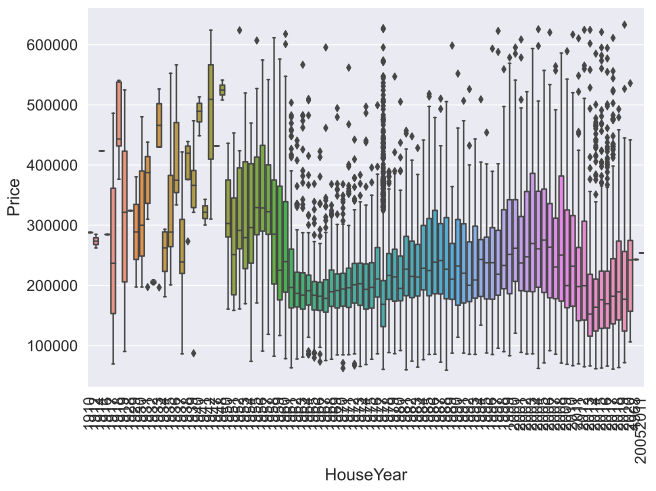

In [653]:
plt.figure(figsize=(10,7))

sns.boxplot(x=train_df['HouseYear'], y=train_df['Price'], whis=1.5)
plt.xticks(rotation=90)

plt.show()

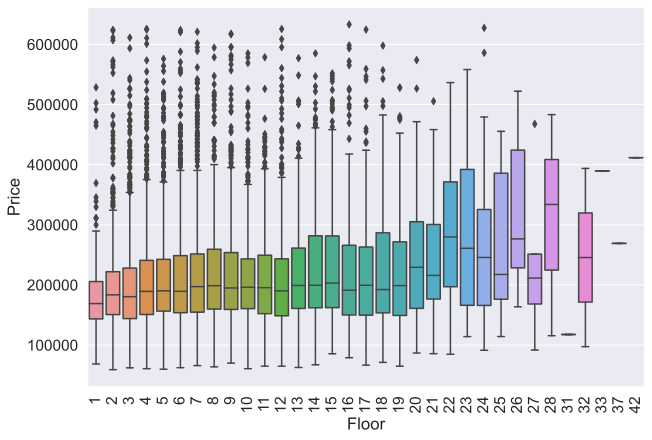

In [654]:
plt.figure(figsize=(10,7))

sns.boxplot(x=train_df['Floor'], y=train_df['Price'], whis=1.5)
plt.xticks(rotation=90)

plt.show()

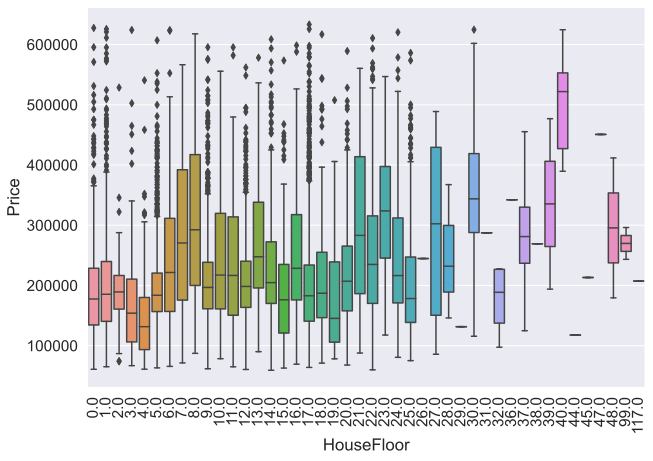

In [655]:
plt.figure(figsize=(10,7))

sns.boxplot(x=train_df['HouseFloor'], y=train_df['Price'], whis=1.5)
plt.xticks(rotation=90)

plt.show()

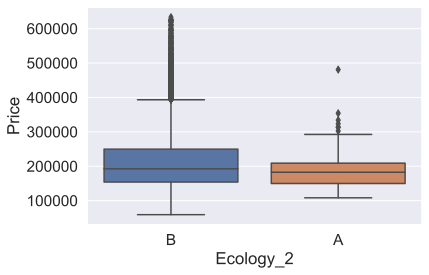

In [656]:
plt.figure()

sns.boxplot(x=train_df['Ecology_2'], y=train_df['Price'], whis=1.5)

plt.show()

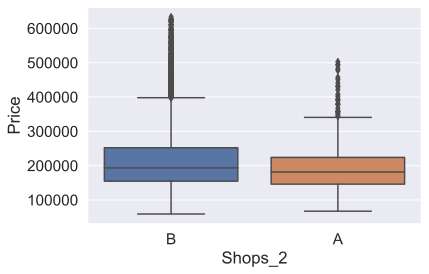

In [657]:
plt.figure()

sns.boxplot(x=train_df['Shops_2'], y=train_df['Price'], whis=1.5)

plt.show()

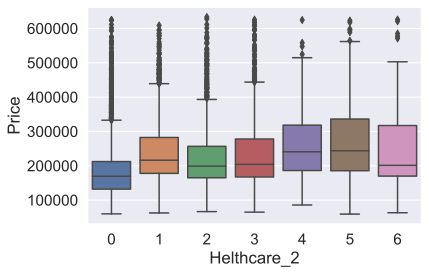

In [658]:
plt.figure()

sns.boxplot(x=train_df['Helthcare_2'], y=train_df['Price'], whis=1.5)

plt.show()

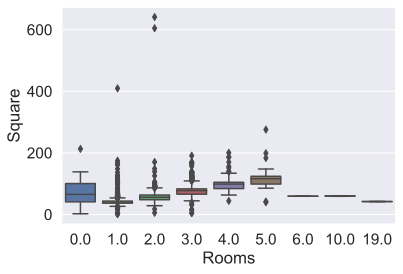

In [659]:
plt.figure()

sns.boxplot(x=train_df['Rooms'], y=train_df['Square'], whis=1.5)

plt.show()

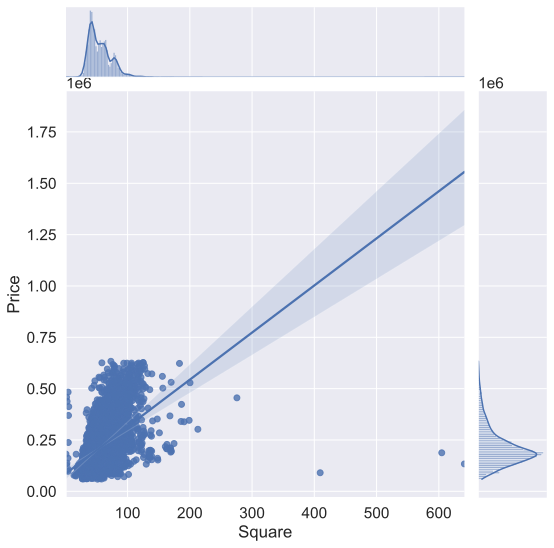

In [660]:
grid = sns.jointplot(train_df['Square'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

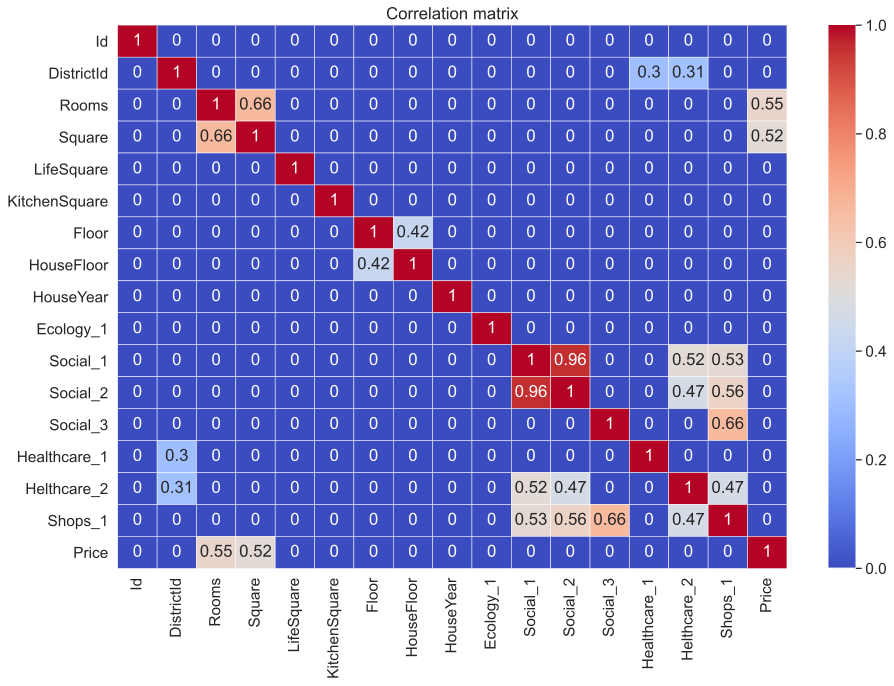

In [661]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [662]:
train_df.groupby(['Rooms'])['Price'].mean()

Rooms
0.0     200435.886261
1.0     159850.800729
2.0     215256.306416
3.0     289337.962452
4.0     383251.100956
5.0     410431.605679
6.0     229661.964416
10.0    244797.297328
19.0     78364.616704
Name: Price, dtype: float64

**Square** 

In [663]:
train_df['Square'].sort_values().unique()

array([  1.13685878,   1.98894272,   2.37724759, ..., 409.42518143,
       604.70597195, 641.06519275])

In [664]:
sum(train_df['LifeSquare'] > train_df['Square'])

482

In [665]:
sum(train_df['KitchenSquare'] > train_df['Square'])

4

In [666]:
sum((train_df['KitchenSquare'] + train_df['LifeSquare']) > train_df['Square'])

845

**HouseFloor, Floor**

In [675]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [676]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [677]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

**HouseYear**

In [678]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7246        2020
2350        2020
8296        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [679]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

## Обработка данных

In [680]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        
        
        
    
    def transform(self, X):
        """Трансформация данных"""
        #District and id to str
        X['Id'] = X['Id'].astype(str)
        X['DistrictId'] = X['DistrictId'].astype(str)

        # Rooms
        
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 4), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 2
        X.loc[X['Rooms'] >= 4, 'Rooms'] = self.medians['Rooms']
        
        
        # Square
        
        condition1 = ((X['KitchenSquare'] < X['Square']) & (X['LifeSquare'] < X['Square']) & \
            ((X['KitchenSquare'] + X['LifeSquare']) < X['Square']))
        
        norm_square = X.loc[condition1, ['Square', 'LifeSquare', 'KitchenSquare']]
        norm_square['%_kitchen'] = norm_square['KitchenSquare'] / norm_square['Square']
        norm_square['%_life'] = norm_square['LifeSquare'] / norm_square['Square']
        
        # fix kitchen square
        
        condition2 = ((X['KitchenSquare'] >= X['Square']) | (X['KitchenSquare'] == 0))

        X.loc[condition2, 'KitchenSquare'] = norm_square['%_kitchen'].median() * X.loc[condition2, 'Square']
        
        # fix life square

        condition3 = (X['LifeSquare'] >= X['Square']) | (X['LifeSquare'].isna())

        X.loc[condition3, 'LifeSquare'] = norm_square['%_life'].median() * X.loc[condition3, 'Square']
        
        # fix kitchen and life square

        condition4 = ((X['KitchenSquare'] + X['LifeSquare']) >= X['Square'])

        X.loc[condition4, 'LifeSquare'] = norm_square['%_life'].median() * X.loc[condition4, 'Square']
        X.loc[condition4, 'KitchenSquare'] = norm_square['%_kitchen'].median() * X.loc[condition4, 'Square']
        
        
        # HouseFloor, Floor
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
        
        
        return X

In [681]:
from feature_engine.discretisation import DecisionTreeDiscretiser
discretizer = DecisionTreeDiscretiser()
from feature_engine.imputation import RandomSampleImputer
rsi = RandomSampleImputer(random_state=54)
rs = RobustScaler()

In [682]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_social_by_district = None
        self.med_ecology_by_district = None
        self.med_health_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1950, 1960, 1985, 2014, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
    
    
        
    def fit(self, X, y=None):
        
        
        discretizer.fit(X[['Square','LifeSquare', 'KitchenSquare', 'HouseFloor', 'Helthcare_2', 'Social_1', 'Social_2','Social_3']], y)
        
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            self.med_social_by_district = df.groupby(['DistrictId'], as_index=False).agg({'Social_3':'median'})\
                                            .rename(columns={'Social_3':'MedSocialByDistrict'})
            self.med_ecology_by_district = df.groupby(['DistrictId'], as_index=False).agg({'Ecology_1':'median'})\
                                            .rename(columns={'Ecology_1':'MedEcologyByDistrict'})
            self.med_health_by_district = df.groupby(['DistrictId'], as_index=False).agg({'Helthcare_2':'median'})\
                                            .rename(columns={'Helthcare_2':'MedHealthByDistrict'})

            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            self.med_social_by_district_median = self.med_social_by_district['MedSocialByDistrict'].median()
            self.med_ecology_by_district_median = self.med_ecology_by_district['MedEcologyByDistrict'].median()
            self.med_health_by_district_median = self.med_health_by_district['MedHealthByDistrict'].median()
        
            
        ## floor, year, square
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            self.square_max = df['Square'].max()
            self.square_min = df['Square'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
        
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
            
  
        

        
    def transform(self, X):
        
        
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        
        
        # More categorical features
        
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        X[['Square_cat','life_square_cat', 'KitchenSquare_cat', 'HouseFloor_cat',  'Helthcare_2_cat',  'Social_1_cat', 'Social_2_cat','Social_3_cat']] = discretizer.transform(X[[ 'Square','LifeSquare', 'KitchenSquare', 
                                                                      'HouseFloor',  'Helthcare_2',  'Social_1', 'Social_2','Social_3']])
        
    
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId'], how='left')
        
        if self.med_social_by_district is not None:
            X = X.merge(self.med_social_by_district, on=['DistrictId'], how='left')
        
        if self.med_ecology_by_district is not None:
            X = X.merge(self.med_ecology_by_district, on=['DistrictId'], how='left')
            
        if self.med_health_by_district is not None:
            X = X.merge(self.med_health_by_district, on=['DistrictId'], how='left')
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        
            
        
        return X
    
    

### 5. Отбор признаков  <a class='anchor' id='feature_selection'>

In [683]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [684]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'Floor', 'LifeSquare', 'KitchenSquare', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2', 'Shops_1', 'Social_1', 'Social_2','Social_3']

new_feature_names = ['DistrictSize',
                    'new_district', 'IsDistrictLarge', 'MedPriceByFloorYear', 'year_cat', 'floor_cat',
                    'Square_cat', 'life_square_cat', 'KitchenSquare_cat', 'HouseFloor_cat',
                    'MedPriceByDistrict', 'MedSocialByDistrict', 'MedEcologyByDistrict', 'MedHealthByDistrict', 'Rooms_outlier',
                     'Social_1_cat', 'Social_2_cat','Social_3_cat']

target_name = 'Price'

### 6. Разбиение на train и test  <a class='anchor' id='split'>

In [685]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [686]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=21)

In [687]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7500, 19), (2500, 19), (5000, 19))

In [688]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((7500, 37), (2500, 37), (5000, 37))

In [689]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [690]:
rsi.fit(X_train)
X_train = rsi.transform(X_train)
X_valid = rsi.transform(X_valid)
test_df = rsi.transform(test_df)

In [691]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 7. Построение модели  <a class='anchor' id='modeling'>

**Обучение**

In [692]:
train_dataset = Pool(X_train, y_train) 
test_dataset = Pool(X_valid, y_valid)

In [693]:
model = CatBoostRegressor(loss_function='RMSE', random_seed=45, iterations = 200, l2_leaf_reg=1, depth = 8, learning_rate=0.1)
model.fit(train_dataset)

0:	learn: 86725.6175868	total: 9.17ms	remaining: 1.82s
1:	learn: 81597.5345546	total: 16.9ms	remaining: 1.67s
2:	learn: 77110.9608233	total: 24.9ms	remaining: 1.63s
3:	learn: 73146.0701549	total: 33ms	remaining: 1.62s
4:	learn: 69800.7849240	total: 40.4ms	remaining: 1.57s
5:	learn: 66967.6177455	total: 48ms	remaining: 1.55s
6:	learn: 64400.1278232	total: 55.3ms	remaining: 1.52s
7:	learn: 62284.7139375	total: 63.1ms	remaining: 1.51s
8:	learn: 60213.7740678	total: 70.1ms	remaining: 1.49s
9:	learn: 58413.8279273	total: 78.2ms	remaining: 1.49s
10:	learn: 56852.7893478	total: 85.7ms	remaining: 1.47s
11:	learn: 55608.6956814	total: 93.9ms	remaining: 1.47s
12:	learn: 54488.2304238	total: 102ms	remaining: 1.46s
13:	learn: 53369.7184227	total: 109ms	remaining: 1.45s
14:	learn: 52423.1833043	total: 117ms	remaining: 1.44s
15:	learn: 51478.8144371	total: 125ms	remaining: 1.43s
16:	learn: 50761.5602178	total: 132ms	remaining: 1.42s
17:	learn: 50110.9450507	total: 139ms	remaining: 1.41s
18:	learn: 4

168:	learn: 30935.0302675	total: 1.42s	remaining: 260ms
169:	learn: 30880.5273353	total: 1.42s	remaining: 251ms
170:	learn: 30820.3974556	total: 1.43s	remaining: 243ms
171:	learn: 30768.0060227	total: 1.44s	remaining: 234ms
172:	learn: 30669.5587119	total: 1.45s	remaining: 226ms
173:	learn: 30631.0247046	total: 1.46s	remaining: 217ms
174:	learn: 30538.4051967	total: 1.46s	remaining: 209ms
175:	learn: 30461.7577677	total: 1.47s	remaining: 201ms
176:	learn: 30401.1747532	total: 1.48s	remaining: 192ms
177:	learn: 30340.0759943	total: 1.49s	remaining: 184ms
178:	learn: 30302.0942761	total: 1.5s	remaining: 176ms
179:	learn: 30222.7107703	total: 1.5s	remaining: 167ms
180:	learn: 30174.9375447	total: 1.51s	remaining: 159ms
181:	learn: 30150.2174192	total: 1.52s	remaining: 150ms
182:	learn: 30104.6426471	total: 1.53s	remaining: 142ms
183:	learn: 30061.8443341	total: 1.53s	remaining: 133ms
184:	learn: 30027.0752259	total: 1.54s	remaining: 125ms
185:	learn: 29992.0066299	total: 1.55s	remaining: 

**Оценка модели**

Train R2:	0.9
Test R2:	0.775


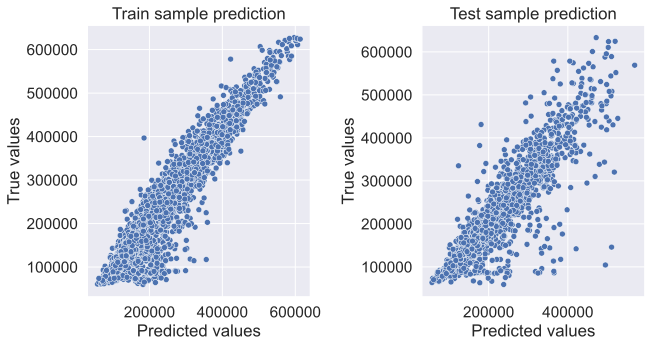

In [694]:
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс-валидация**

In [695]:
cv_score = cross_val_score(model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

0:	learn: 86145.1588126	total: 7.56ms	remaining: 1.5s
1:	learn: 81245.3269767	total: 14.9ms	remaining: 1.48s
2:	learn: 76811.6687244	total: 22.1ms	remaining: 1.45s
3:	learn: 72915.4577802	total: 29.2ms	remaining: 1.43s
4:	learn: 69547.1307980	total: 36.7ms	remaining: 1.43s
5:	learn: 66616.2676723	total: 44.2ms	remaining: 1.43s
6:	learn: 64064.8382563	total: 51.6ms	remaining: 1.42s
7:	learn: 61852.1638583	total: 59ms	remaining: 1.42s
8:	learn: 59850.9344496	total: 67.2ms	remaining: 1.43s
9:	learn: 58052.2950317	total: 75.3ms	remaining: 1.43s
10:	learn: 56559.7465763	total: 83.1ms	remaining: 1.43s
11:	learn: 55215.6400373	total: 90.7ms	remaining: 1.42s
12:	learn: 54100.3976631	total: 97.8ms	remaining: 1.41s
13:	learn: 52939.2627180	total: 106ms	remaining: 1.4s
14:	learn: 51931.0817365	total: 113ms	remaining: 1.39s
15:	learn: 51015.2530147	total: 120ms	remaining: 1.38s
16:	learn: 50323.0869905	total: 126ms	remaining: 1.36s
17:	learn: 49647.8110281	total: 134ms	remaining: 1.35s
18:	learn: 

163:	learn: 29251.7182230	total: 1.23s	remaining: 270ms
164:	learn: 29204.1009624	total: 1.24s	remaining: 263ms
165:	learn: 29157.4840971	total: 1.25s	remaining: 255ms
166:	learn: 29091.6312468	total: 1.25s	remaining: 247ms
167:	learn: 29044.7072206	total: 1.26s	remaining: 240ms
168:	learn: 28962.2657708	total: 1.27s	remaining: 232ms
169:	learn: 28884.5855050	total: 1.27s	remaining: 225ms
170:	learn: 28815.8078034	total: 1.28s	remaining: 217ms
171:	learn: 28765.0760748	total: 1.29s	remaining: 210ms
172:	learn: 28690.3775187	total: 1.29s	remaining: 202ms
173:	learn: 28653.6993068	total: 1.3s	remaining: 195ms
174:	learn: 28599.1693797	total: 1.31s	remaining: 187ms
175:	learn: 28549.1578400	total: 1.32s	remaining: 180ms
176:	learn: 28459.3386377	total: 1.32s	remaining: 172ms
177:	learn: 28393.4026360	total: 1.33s	remaining: 164ms
178:	learn: 28326.9161193	total: 1.34s	remaining: 157ms
179:	learn: 28249.6346114	total: 1.34s	remaining: 149ms
180:	learn: 28190.0958624	total: 1.35s	remaining:

124:	learn: 32426.5836185	total: 894ms	remaining: 536ms
125:	learn: 32338.7017972	total: 901ms	remaining: 529ms
126:	learn: 32299.0908115	total: 909ms	remaining: 522ms
127:	learn: 32250.3146086	total: 916ms	remaining: 515ms
128:	learn: 32136.8519994	total: 923ms	remaining: 508ms
129:	learn: 32051.1394841	total: 930ms	remaining: 501ms
130:	learn: 31948.3518532	total: 937ms	remaining: 494ms
131:	learn: 31856.1231037	total: 944ms	remaining: 486ms
132:	learn: 31781.1511766	total: 951ms	remaining: 479ms
133:	learn: 31710.2374818	total: 958ms	remaining: 472ms
134:	learn: 31579.7420939	total: 965ms	remaining: 465ms
135:	learn: 31503.9582644	total: 972ms	remaining: 457ms
136:	learn: 31434.9950282	total: 979ms	remaining: 450ms
137:	learn: 31392.8563783	total: 986ms	remaining: 443ms
138:	learn: 31252.9487191	total: 994ms	remaining: 436ms
139:	learn: 31205.0492849	total: 1s	remaining: 429ms
140:	learn: 31168.0840232	total: 1.01s	remaining: 422ms
141:	learn: 31080.0004346	total: 1.01s	remaining: 4

85:	learn: 35858.7391796	total: 614ms	remaining: 814ms
86:	learn: 35779.2840074	total: 621ms	remaining: 806ms
87:	learn: 35705.8882335	total: 628ms	remaining: 799ms
88:	learn: 35660.7598058	total: 635ms	remaining: 792ms
89:	learn: 35589.0997280	total: 643ms	remaining: 785ms
90:	learn: 35485.8783099	total: 650ms	remaining: 778ms
91:	learn: 35393.0175402	total: 656ms	remaining: 771ms
92:	learn: 35286.4218806	total: 664ms	remaining: 763ms
93:	learn: 35168.7001942	total: 671ms	remaining: 756ms
94:	learn: 34992.8444032	total: 678ms	remaining: 749ms
95:	learn: 34930.5815529	total: 684ms	remaining: 741ms
96:	learn: 34877.2155844	total: 691ms	remaining: 734ms
97:	learn: 34779.3505080	total: 699ms	remaining: 727ms
98:	learn: 34687.5442400	total: 705ms	remaining: 720ms
99:	learn: 34622.3385699	total: 712ms	remaining: 712ms
100:	learn: 34417.5706865	total: 719ms	remaining: 705ms
101:	learn: 34278.9610692	total: 726ms	remaining: 697ms
102:	learn: 34181.8943389	total: 733ms	remaining: 690ms
103:	le

45:	learn: 41253.0860584	total: 392ms	remaining: 1.31s
46:	learn: 41024.8855287	total: 399ms	remaining: 1.3s
47:	learn: 40915.6760843	total: 405ms	remaining: 1.28s
48:	learn: 40715.8969841	total: 411ms	remaining: 1.27s
49:	learn: 40426.1673981	total: 418ms	remaining: 1.25s
50:	learn: 40278.3259628	total: 424ms	remaining: 1.24s
51:	learn: 40135.0817869	total: 430ms	remaining: 1.23s
52:	learn: 40011.0240789	total: 437ms	remaining: 1.21s
53:	learn: 39851.1545755	total: 444ms	remaining: 1.2s
54:	learn: 39735.7502183	total: 450ms	remaining: 1.19s
55:	learn: 39526.5842221	total: 457ms	remaining: 1.18s
56:	learn: 39432.1078005	total: 463ms	remaining: 1.16s
57:	learn: 39247.4450545	total: 470ms	remaining: 1.15s
58:	learn: 39189.0235756	total: 477ms	remaining: 1.14s
59:	learn: 39030.8224089	total: 486ms	remaining: 1.14s
60:	learn: 38937.1925078	total: 494ms	remaining: 1.12s
61:	learn: 38849.8541356	total: 500ms	remaining: 1.11s
62:	learn: 38744.1667038	total: 508ms	remaining: 1.1s
63:	learn: 38

0:	learn: 87288.3300388	total: 7.78ms	remaining: 1.55s
1:	learn: 82498.9256401	total: 14.8ms	remaining: 1.47s
2:	learn: 78131.8117658	total: 21.3ms	remaining: 1.4s
3:	learn: 74280.2202658	total: 27.5ms	remaining: 1.35s
4:	learn: 70804.7867020	total: 34.4ms	remaining: 1.34s
5:	learn: 67872.8469341	total: 40.8ms	remaining: 1.32s
6:	learn: 65374.8640456	total: 47.5ms	remaining: 1.31s
7:	learn: 63143.0671300	total: 54.5ms	remaining: 1.31s
8:	learn: 61056.4624197	total: 61.1ms	remaining: 1.29s
9:	learn: 59094.1881477	total: 67.9ms	remaining: 1.29s
10:	learn: 57691.4840536	total: 71.2ms	remaining: 1.22s
11:	learn: 56321.2647849	total: 78ms	remaining: 1.22s
12:	learn: 54987.3650479	total: 84.9ms	remaining: 1.22s
13:	learn: 53772.0982657	total: 91.8ms	remaining: 1.22s
14:	learn: 52762.2920276	total: 98.9ms	remaining: 1.22s
15:	learn: 51937.0287481	total: 105ms	remaining: 1.21s
16:	learn: 51150.5120155	total: 112ms	remaining: 1.21s
17:	learn: 50340.1153191	total: 118ms	remaining: 1.2s
18:	learn

159:	learn: 30187.5283819	total: 1.06s	remaining: 264ms
160:	learn: 30144.0364696	total: 1.06s	remaining: 258ms
161:	learn: 30066.8618182	total: 1.07s	remaining: 251ms
162:	learn: 30045.0488274	total: 1.08s	remaining: 245ms
163:	learn: 29990.0398019	total: 1.08s	remaining: 238ms
164:	learn: 29910.9330206	total: 1.09s	remaining: 231ms
165:	learn: 29831.5922190	total: 1.1s	remaining: 225ms
166:	learn: 29740.9699677	total: 1.1s	remaining: 218ms
167:	learn: 29677.3220878	total: 1.11s	remaining: 212ms
168:	learn: 29611.2888369	total: 1.12s	remaining: 205ms
169:	learn: 29523.6978796	total: 1.12s	remaining: 198ms
170:	learn: 29442.3544513	total: 1.13s	remaining: 192ms
171:	learn: 29358.8619659	total: 1.14s	remaining: 185ms
172:	learn: 29321.7453512	total: 1.14s	remaining: 178ms
173:	learn: 29260.5686431	total: 1.15s	remaining: 172ms
174:	learn: 29125.3645924	total: 1.16s	remaining: 165ms
175:	learn: 29070.1365835	total: 1.16s	remaining: 159ms
176:	learn: 29020.0366697	total: 1.17s	remaining: 

array([0.75492312, 0.72392063, 0.74734382, 0.75077373, 0.74890292])

In [696]:
cv_score.mean()

0.7451728427311718

**Важность признаков**

In [697]:
feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

feature_name  importance
27    MedPriceByDistrict   15.956302
2                 Square   14.460896
23            Square_cat   11.022366
7              HouseYear    4.664889
17          DistrictSize    4.227020
4             LifeSquare    3.507891
33          Social_2_cat    3.346199
5          KitchenSquare    3.303836
8              Ecology_1    3.045591
28   MedSocialByDistrict    2.930348
16              Social_3    2.705233
20   MedPriceByFloorYear    2.395980
14              Social_1    2.374540
26        HouseFloor_cat    2.371628
15              Social_2    2.338492
1                  Rooms    2.238367
6             HouseFloor    2.131431
29  MedEcologyByDistrict    2.037283
25     KitchenSquare_cat    1.860250
0             DistrictId    1.702659
24       life_square_cat    1.685786
3                  Floor    1.572465
13               Shops_1    1.524461
12           Helthcare_2    1.136733
34          Social_3_cat    1.010468
32          Social_1_cat    0.922641
22             floor_cat    0.867552
19       IsDistrictLarge    0.855498
21              year_cat    0.779128
30   MedHealthByDistrict    0.471649
31         Rooms_outlier    0.410879
11               Shops_2    0.132689
10             Ecology_3    0.008848
18          new_district    0.000000
9              Ecology_2    0.000000

### 8. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>


In [698]:
test_df.shape

(5000, 35)

In [699]:
test_df

DistrictId  Rooms     Square  Floor  LifeSquare  KitchenSquare  \
0            44    1.0  36.847630      5   19.094182            5.0   
1            62    1.0  42.493907      7   25.799208           10.0   
2            27    2.0  59.463678     19   36.102018            9.0   
3            23    3.0  49.646030      2   33.893825            6.0   
4            74    1.0  53.837056      8   32.685942            1.0   
...         ...    ...        ...    ...         ...            ...   
4995         29    2.0  43.177521      2   30.339945            5.0   
4996         38    3.0  93.698122     21   56.886681           10.0   
4997        101    1.0  33.656723      2   19.003259            5.0   
4998         10    1.0  38.635155      8   20.976257            9.0   
4999         21    2.0  67.122742      9   33.944344           13.0   

      HouseFloor  HouseYear  Ecology_1  Ecology_2  ...  KitchenSquare_cat  \
0            9.0       1970   0.036122          1  ...      185586.628843   
1           17.0       2017   0.072158          1  ...      263936.036302   
2           19.0       1977   0.211401          1  ...      235779.695579   
3            2.0       1965   0.014073          1  ...      200437.161950   
4           17.0       1977   0.309479          1  ...      185586.628843   
...          ...        ...        ...        ...  ...                ...   
4995         5.0       1962   0.069660          1  ...      185586.628843   
4996        27.0       2018   0.060753          1  ...      263936.036302   
4997         5.0       1966   0.038693          1  ...      185586.628843   
4998        14.0       1970   0.089040          1  ...      235779.695579   
4999        17.0       2009   0.194489          1  ...      275183.206641   

      HouseFloor_cat  MedPriceByDistrict  MedSocialByDistrict  \
0      216659.369086       206400.446460                  0.0   
1      201664.126034       162537.996292                  1.0   
2      201664.126034       147040.226120                  0.0   
3      171121.433555       113619.866839                  0.0   
4      201664.126034       212801.122972                  3.0   
...              ...                 ...                  ...   
4995   196862.083798       174962.639679                  4.0   
4996   205826.791755       300050.531161                  2.0   
4997   196862.083798       184743.663258                  7.0   
4998   216659.369086       220082.015992                  5.0   
4999   201664.126034       182131.992548                  3.0   

      MedEcologyByDistrict  MedHealthByDistrict  Rooms_outlier   Social_1_cat  \
0                 0.036122                  1.0              0  231358.736536   
1                 0.072158                  0.0              0  167721.157800   
2                 0.072158                  0.0              0  152764.148462   
3                 0.034656                  0.0              0  167721.157800   
4                 0.075779                  0.0              0  231358.736536   
...                    ...                  ...            ...            ...   
4995              0.069660                  1.0              0  231358.736536   
4996              0.060753                  0.0              0  294017.909501   
4997              0.225825                  3.0              0  231358.736536   
4998              0.089040                  0.0              0  231358.736536   
4999              0.194489                  3.0              0  231358.736536   

       Social_2_cat   Social_3_cat  
0     249624.280133  180193.364941  
1     161911.962696  191718.902808  
2     161911.962696  180193.364941  
3     161911.962696  180193.364941  
4     244391.733287  249662.002018  
...             ...            ...  
4995  215199.605388  249662.002018  
4996  249624.280133  240702.399542  
4997  189807.544665  191718.902808  
4998  244391.733287  249662.002018  
4999  244391.733287  201884.331992  

[5000 rows x 35 columns]

In [700]:
submit = pd.read_csv('kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

Id     Price
0  4567  200000.0
1  5925  200000.0
2   960  200000.0
3  3848  200000.0
4   746  200000.0

In [701]:
predictions = model.predict(test_df)
predictions

array([168048.55316088, 119305.56679233, 148908.88933417, ...,
       148853.07818555, 189827.43049826, 270353.12031729])

In [702]:
submit['Price'] = predictions
submit.head()

Id          Price
0  4567  168048.553161
1  5925  119305.566792
2   960  148908.889334
3  3848  103999.447159
4   746  202922.836749

In [703]:
submit.to_csv('rf_submit.csv', index=False)